In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import os
import os.path as osp 
import json
from tqdm import tqdm
import random

from datasets.bases import read_image
from utils.metrics import euclidean_distance, cosine_similarity, eval_func
from analyse import *

In [18]:
print("Loading data!")
output_dir = "/export/livia/home/vision/Rbhattacharya/work/TransReID/outputs/train_msmt17_cam12345"
feature_type = "og"
distmat = torch.load(osp.join(output_dir, f"distmat_{feature_type}.pth"))
pids = torch.load(osp.join(output_dir, "pids.pth"))
camids = torch.load(osp.join(output_dir, "camids.pth"))
with open(osp.join(output_dir, "imgpaths.json"), 'r') as f:
    file_content = f.read()  # Read the entire content of the file as a string
    imgpaths = json.loads(file_content) 
#p = pids
#pids = distmat
#distmat = p
#p = camids
#camids = pids
#pids = p
qf, gf = torch.load(osp.join(output_dir, f"qf_{feature_type}.pth")), torch.load(osp.join(output_dir, f"gf_{feature_type}.pth"))
indices = np.argsort(distmat, axis=1)
print("Loaded successfully!")

Loading data!


/tmp/ipykernel_3544057/3233737011.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  distmat = torch.load(osp.join(output_dir, f"distmat_{feature_type}.pth"))
/tmp/ipykerne

Loaded successfully!


In [19]:
feats = {}

for i in range(gf.shape[0]):
    #print(gf[i].shape)
    if str(camids[qf.shape[0] + i]) in list(feats.keys()): feats[str(camids[qf.shape[0] + i])].append(gf[i].numpy().tolist())
    else: feats[str(camids[qf.shape[0] + i])] = [gf[i].numpy().tolist()]

for k,v in feats.items():
    print(k, len(v))
    feats[k] = random.sample(v, 500)
    print(k, len(feats[k]))

correct = 0
sample_size = 1000
for i in tqdm(range(min(sample_size, qf.shape[0]))):
    c = knn_classify(feats, qf[i].numpy().tolist(), k=15)
    
    if int(c) == camids[i]: correct += 1
    if i == sample_size: break
acc = (correct / sample_size) * 100
print(f"k-NN Accuracy: {acc:.3f}")





plot_umap_feats(feats, output_dir + f"/ft_{feature_type}_umap.png")

0 12368
0 500
4 11018
4 500
13 10310
13 500
6 8199
6 500
14 3390
14 500
2 1319
2 500
3 3440
3 500
8 3377
8 500
11 3136
11 500
10 7571
10 500
12 9068
12 500
7 2235
7 500
5 4159
5 500
9 1958
9 500
1 613
1 500


100%|██████████| 1000/1000 [06:46<00:00,  2.46it/s]
/export/livia/home/vision/Rbhattacharya/anaconda3/envs/clipreid/lib/python3.8/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


k-NN Accuracy: 60.200
Loading data
Loaded all data..processing umap
Processing umap done...saving


In [37]:
feats_q, pid_q = {}, {}
feats_g, pid_g = {}, {}
cq_ids, cg_ids = [], []
topk = 5
for i in range(qf.shape[0]):
    #print(gf[i].shape)
    if str(camids[i]) in list(feats_q.keys()): 
        feats_q[str(camids[i])].append(qf[i].numpy().tolist())
        pid_q[str(camids[i])].append(pids[i])
    else: 
        feats_q[str(camids[i])] = [qf[i].numpy().tolist()]
        pid_q[str(camids[i])] = [pids[i]]

for i in range(gf.shape[0]):
    #print(gf[i].shape)
    if str(camids[qf.shape[0] + i]) in list(feats_g.keys()): 
        feats_g[str(camids[qf.shape[0] + i])].append(gf[i].numpy().tolist())
        pid_g[str(camids[qf.shape[0] + i])].append(pids[qf.shape[0] + i])
    else: 
        feats_g[str(camids[qf.shape[0] + i])] = [gf[i].numpy().tolist()]
        pid_g[str(camids[qf.shape[0] + i])] = [pids[qf.shape[0] + i]]

for k,v in feats_q.items():
    testcase = torch.tensor(feats_q[k])
    
    # testcase_mask = torch.argsort(torch.tensor(feats_q[k] + feats_g[k]).var(dim=0), dim=0, descending=False)
    # testcase_mask = torch.tensor(feats_q[k] + feats_g[k]).var(dim=0)
    # testcase_mask = (testcase_mask - testcase_mask.min()) / (testcase_mask.max() - testcase_mask.min())
    # print(k, torch.tensor(feats_q[k] + feats_g[k]).var(dim=0))
    # print(k, testcase_mask)
    # testcase_idx = testcase_mask.repeat(testcase.shape[0], 1)
    
    # break
    # testcase[testcase_idx < topk] = 0
    mean = testcase.mean(dim=0).mean()
    std = testcase.mean(dim=0).mean()
    # print(mean.shape)
    testcase = (testcase - mean) / std
    print(k, testcase.shape)
    feats_q[k] = testcase
    pid_q[k] = torch.tensor(pid_q[k])
    cq_ids += [int(k) for i in range(len(v))]
    cg_ids += [int(k) for i in range(len(feats_g[k]))]

    testcase = torch.tensor(feats_g[k])
    # testcase_idx = testcase_mask.repeat(testcase.shape[0], 1)
    #testcase_idx = torch.argsort(testcase.var(dim=0)).repeat(testcase.shape[0], 1)
    # testcase[testcase_idx < topk] = 0
    # testcase *= testcase_idx
    mean = testcase.mean(dim=0).mean()
    std = testcase.mean(dim=0).mean()
    testcase = (testcase - mean) / std
    feats_g[k] = testcase
    pid_g[k] = torch.tensor(pid_g[k])
    

# for k,v in feats_g.items():
#     testcase = torch.tensor(feats_g[k])
#     testcase_idx = torch.argsort(testcase.var(dim=0)).repeat(testcase.shape[0], 1)
#     testcase[testcase_idx > topk] = 0
#     feats_g[k] = testcase
#     pid_g[k] = torch.tensor(pid_g[k])
#     cg_ids += [int(k) for i in range(len(v))]

qf_new, gf_new, p1, p2 = [], [], [], []
for k,v in feats_q.items():
    qf_new.append(v)
    gf_new.append(feats_g[k])
    p1.append(pid_q[k])
    p2.append(pid_g[k])

pids_new = p1 + p2
pids_new = torch.cat(pids_new, dim=0)
qf_new, gf_new = torch.cat(qf_new, dim=0), torch.cat(gf_new, dim=0)

print(qf_new.shape, gf_new.shape, pids_new.shape)

0 torch.Size([1882, 1280])
13 torch.Size([1511, 1280])
6 torch.Size([1202, 1280])
14 torch.Size([432, 1280])
4 torch.Size([1689, 1280])
2 torch.Size([186, 1280])
11 torch.Size([381, 1280])
3 torch.Size([480, 1280])
5 torch.Size([524, 1280])
7 torch.Size([302, 1280])
10 torch.Size([1007, 1280])
12 torch.Size([1246, 1280])
8 torch.Size([445, 1280])
9 torch.Size([294, 1280])
1 torch.Size([78, 1280])
torch.Size([11659, 1280]) torch.Size([82161, 1280]) torch.Size([93820])


In [38]:
from utils.metrics import *
q_pids = pids_new[:qf.shape[0]].numpy()
g_pids = pids_new[qf.shape[0]:].numpy()
cq_ids, cg_ids = np.array(cq_ids), np.array(cg_ids)
distmat_new = euclidean_distance(qf=qf_new.cuda(), gf=gf_new.cuda())
cmc, mAP = eval_func(distmat_new, q_pids, g_pids, cq_ids, cg_ids, exclude_cam=None)

print(mAP)
print(cmc[0], cmc[4], cmc[9])


100%|██████████| 11659/11659 [00:16<00:00, 702.47it/s]


0.34478633183515045
0.58984476 0.7364268 0.78909


In [33]:
init_pop = 100
init_imm = 0.2

delta_pop = 50
delta_imm = 0.2

pop = init_pop
imm_pop = init_pop * init_imm
for i in range(10):
    pop = pop + delta_pop
    imm_pop = imm_pop + delta_pop * delta_imm
    print(f"Year: {i}, Total population: {pop}, Immigrant population: {imm_pop}, immigrant %: {(imm_pop/pop * 100):.3f}")

pop = init_pop
imm_pop = init_pop * init_imm
for i in range(10):
    pop = pop + delta_pop
    imm_pop = imm_pop + delta_pop * delta_imm
    print(f"Year: {i}, Total population: {pop}, Immigrant population: {imm_pop}, immigrant %: {(imm_pop/pop * 100):.3f}")

Year: 0, Total population: 150, Immigrant population: 30.0, immigrant %: 20.000
Year: 1, Total population: 200, Immigrant population: 40.0, immigrant %: 20.000
Year: 2, Total population: 250, Immigrant population: 50.0, immigrant %: 20.000
Year: 3, Total population: 300, Immigrant population: 60.0, immigrant %: 20.000
Year: 4, Total population: 350, Immigrant population: 70.0, immigrant %: 20.000
Year: 5, Total population: 400, Immigrant population: 80.0, immigrant %: 20.000
Year: 6, Total population: 450, Immigrant population: 90.0, immigrant %: 20.000
Year: 7, Total population: 500, Immigrant population: 100.0, immigrant %: 20.000
Year: 8, Total population: 550, Immigrant population: 110.0, immigrant %: 20.000
Year: 9, Total population: 600, Immigrant population: 120.0, immigrant %: 20.000


[Text(0, -15, 'PID: 5; \n CID: 0; \n D: 0.18'),
 Text(0, -15, 'PID: 5; \n CID: 0; \n D: 0.21'),
 Text(0, -15, 'PID: 5; \n CID: 0; \n D: 0.22'),
 Text(0, -15, 'PID: 5; \n CID: 0; \n D: 0.22'),
 Text(0, -15, 'PID: 5; \n CID: 0; \n D: 0.23'),
 Text(0, -15, 'PID: 282; \n CID: 0; \n D: 0.24'),
 Text(0, -15, 'PID: 5; \n CID: 0; \n D: 0.24'),
 Text(0, -15, 'PID: 1802; \n CID: 0; \n D: 0.25'),
 Text(0, -15, 'PID: 1803; \n CID: 0; \n D: 0.25'),
 Text(0, -15, 'PID: 1769; \n CID: 0; \n D: 0.26')]

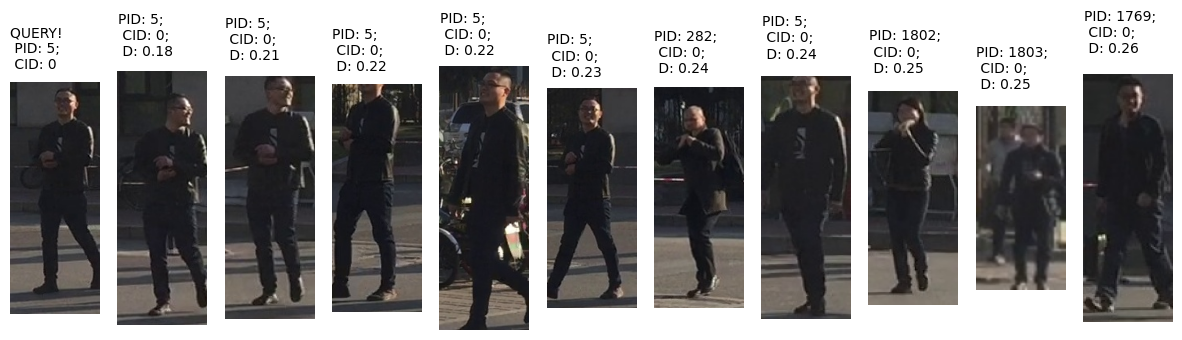

In [4]:
# Choose query index and top-k:
idx, k = 23, 10
D = distmat[idx, :]
D_ids = indices[idx, :k]

gallery_paths = np.array(imgpaths)[qf.shape[0] + D_ids]
query_path = imgpaths[idx]

_, ax = plt.subplots(1, 1+k, figsize=(15, k))
[a.axis('off') for a in ax.flatten()]
ax[0].imshow(read_image(query_path))
ax[0].text(0, -15, f"QUERY! \n PID: {pids[idx]}; \n CID: {camids[idx]}")
[ax[i+1].imshow(read_image(gallery_paths[i])) for i in range(k)]
[ax[i+1].text(0, -15, f"PID: {pids[qf.shape[0] + D_ids[i]]}; \n CID: {camids[qf.shape[0] + D_ids[i]]}; \n D: {D[D_ids[i]]:.2f}") for i in range(k)]

In [4]:
# Expected Calibration Error
print(distmat.min(), distmat.max())

-9.4249845e-07 1.1689022


In [20]:
pcount, ccount = 0, 0
dists = []
delta = 0
for i in tqdm(range(qf.shape[0]), total=qf.shape[0]):
    p = pids[i]
    c = camids[i]
    p_pred = pids[qf.shape[0] + indices[i, 0]]
    c_pred = camids[qf.shape[0] + indices[i, 0]]
    if p == p_pred: pcount += 1
    if c == c_pred: ccount += 1
    if p == p_pred and c == c_pred: 
        delta += 1
        continue
    dists.append(distmat[i, 0])
    #print(p, c, p_pred, c_pred, dists[-1])
    #if i == 10: break

pp = ((pcount - delta) / (qf.shape[0] - delta)) * 100.0
cp = ((ccount - delta) / (qf.shape[0] - delta)) * 100.0
print(f"Correct ID Percentage: {pp:.3f}, Matching camera percentage: {cp:.3f}")
dists = torch.tensor(dists)
print(f"Rank 1 Distance Stats: Min: {dists.min().item():.3f}, Max: {dists.max().item():.3f}, Mean: {dists.mean().item():.3f}, Std: {dists.std().item():.3f}")

100%|██████████| 11659/11659 [00:00<00:00, 421327.62it/s]

Correct ID Percentage: 34.609, Matching camera percentage: 51.914
Rank 1 Distance Stats: Min: 0.845, Max: 2.128, Mean: 1.637, Std: 0.178
